In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Static FC and Dynamic FC

In [2]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

yeo  = datasets.fetch_atlas_yeo_2011()
data = datasets.fetch_development_fmri(n_subjects=10)

# create masker to extract functional data within atlas parcels
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,
                           memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

In [3]:
# static FC
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series[0]])[0]

In [8]:
time_series[0].shape

(168, 17)

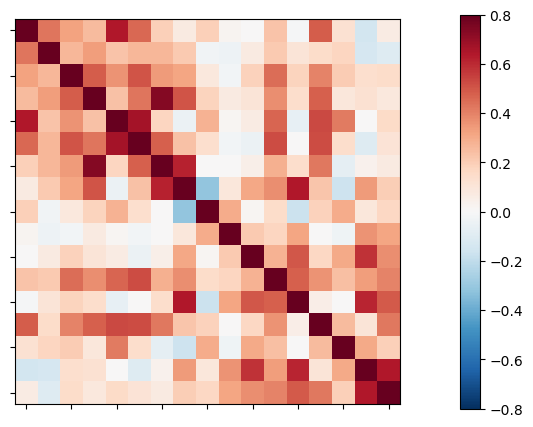

In [4]:
# useful for plotting connectivity interactions on glass brain
from nilearn import plotting

corr_plot = plotting.plot_matrix(correlation_matrix, figure=(5, 5), vmax=0.8, vmin=-0.8)

In [12]:
# dynamic FC
specimen = 0
nbr, nbt = time_series[specimen].T.shape

# no overlap dynamic FC with window size 20
ws  = 20
dFC = np.zeros((nbt // ws + 1, nbr,nbr))
for c, sidx in enumerate(range(0, nbt, ws)):
    T = time_series[specimen][sidx:sidx+ws]
    if T.shape[0] != ws: 
        continue
    correlation_measure = ConnectivityMeasure(kind='correlation')
    dFC[c] = correlation_measure.fit_transform([T])[0]

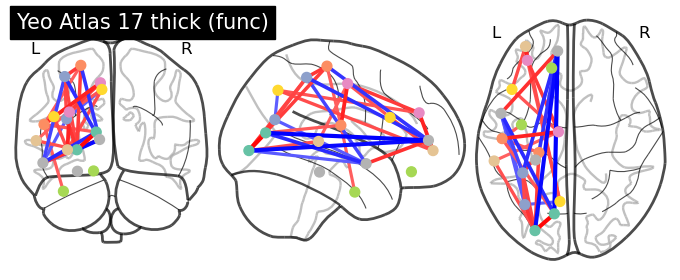

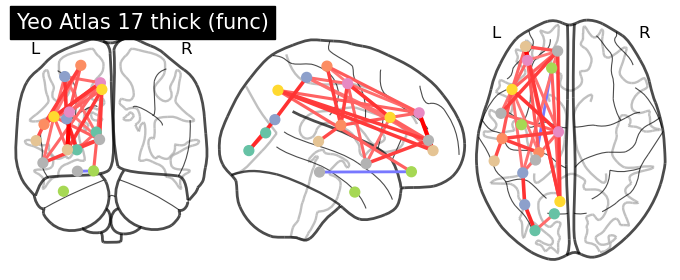

In [13]:
# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(dFC[0], coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')

plotting.plot_connectome(dFC[1], coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')

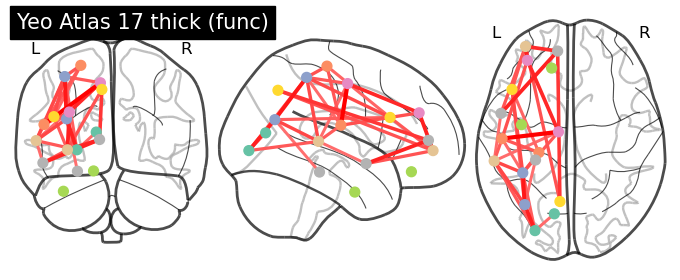

In [14]:
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])
plotting.plot_connectome(correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')

### Gradients
We use here a simple 20 sample point window in the dynamic FC

In [15]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle
gref = GradientMaps(n_components=2, approach='dm', kernel='normalized_angle')

# and fit to the data
gref.fit(correlation_matrix)
G = []

for widx in range(0, len(dFC)):
    if np.all(dFC[widx] == 0): continue
    galign = GradientMaps(n_components=2, kernel='normalized_angle', approach='le', alignment='procrustes')
    galign.fit(dFC[widx], reference=gref.gradients_)
    G.append(galign.gradients_)

G = np.asarray(G)

Text(0.5, 1.0, 'principal gradient')

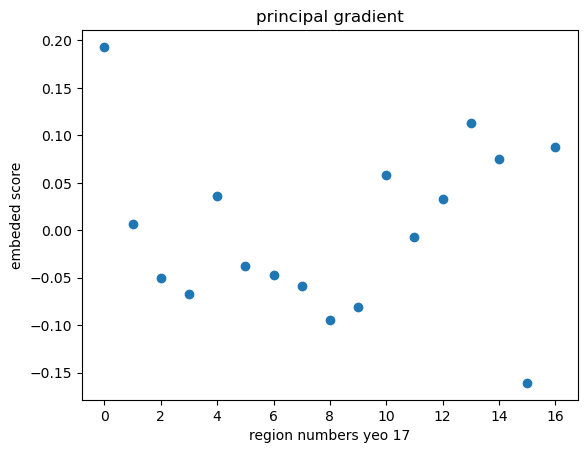

In [27]:
plt.scatter(np.arange(len(G[0])),G[0][:,0])
plt.xlabel('region numbers yeo 17')
plt.ylabel('embeded score')
plt.title('principal gradient')

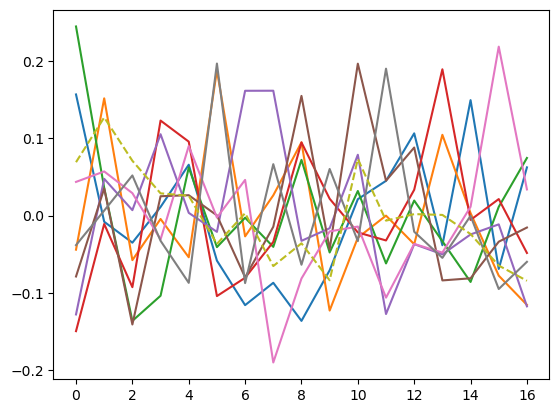

In [133]:
for i in range(len(G)):
    plt.plot(G[i,:,0])
plt.plot(gref.gradients_[:,0], '--')

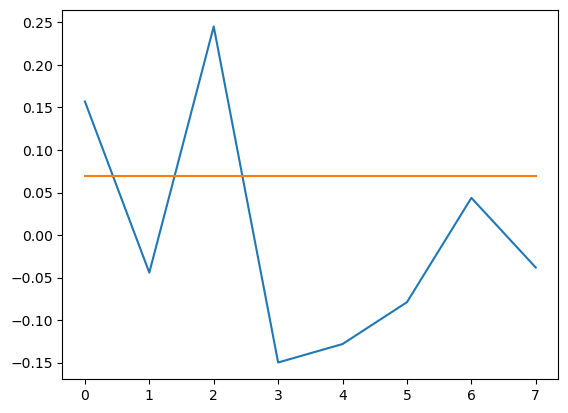

In [136]:
plt.plot(G[:,0,0])
plt.plot(np.arange(len(G)), [gref.gradients_[0,0]] * len(G))

### Gradients Visualization

In [137]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69

# First load mean connectivity matrix and Schaefer parcellation
conn_matrix = load_group_fc('schaefer', scale=400)
labeling = load_parcellation('schaefer', scale=400, join=True)

# and load the conte69 surfaces
surf_lh, surf_rh = load_conte69()

In [138]:
from brainspace.gradient import GradientMaps

# Ask for 10 gradients (default)
gm = GradientMaps(n_components=10, random_state=0)
gm.fit(conn_matrix)

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(random_state=0)

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


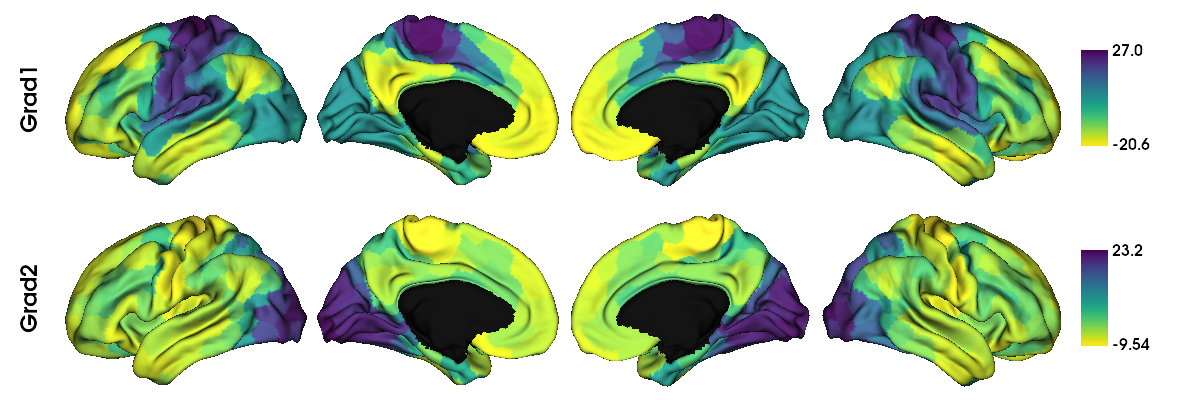

: 

In [139]:
import numpy as np
from brainspace.plotting import plot_hemispheres

from brainspace.utils.parcellation import map_to_labels

mask = labeling != 0

grad = [None] * 2
for i in range(2):
    # map the gradient to the parcels
    grad[i] = map_to_labels(gm.gradients_[:, i], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1200, 400), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1', 'Grad2'], zoom=1.55, embed_nb=True)